# 03 — LAMA baselines (2 configs)

Requirements satisfied:
- **minimum 2 different LAMA configurations**
- choose the best validation score
- avoid leakage: we use time-aware holdout split

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if (PROJECT_ROOT / "src").exists() is False and (PROJECT_ROOT.parent / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("src exists:", (PROJECT_ROOT / "src").exists())

PROJECT_ROOT: /Users/sergey/code/renthop-lightautoml-vs-custom
src exists: True


In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

from src.config import Paths, TARGET_COL, ID_COL, SEED
from src.models.lama import fit_lama_tabular, fit_lama_tabular_nlp
from src.utils.seed import set_global_seed

set_global_seed(SEED)
paths = Paths()

df = pd.read_pickle(paths.data_processed/"model_table.pkl")
spec = json.loads((paths.data_processed/"feature_spec.json").read_text(encoding="utf-8"))

# Split back to train/test by presence of target
train_df = df[df[TARGET_COL].notna()].copy()
test_df  = df[df[TARGET_COL].isna()].copy()

# Time-aware holdout: last 20% by created_dt
train_df = train_df.sort_values("created_dt")
cut = int(len(train_df) * 0.8)
tr, va = train_df.iloc[:cut], train_df.iloc[cut:]
print("train:", tr.shape, "valid:", va.shape)

/Users/sergey/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sergey/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


train: (39481, 34) valid: (9871, 34)


In [5]:
labels = ["high","medium","low"]  # submission column order
y_va = va[TARGET_COL].values

drop_cols = [ID_COL, "created_dt"]  # keep only engineered numeric/cat/text cols

# --- Config A: TabularAutoML (fast-ish) ---
res_a = fit_lama_tabular(
    train_df=tr,
    valid_df=va,
    target_col=TARGET_COL,
    drop_cols=drop_cols + spec["text_cols"],  # tabular-only: drop raw text
    timeout=600,
    cpu_limit=4,
    params={"use_algos": [["lgb"]]},  # simple, strong baseline
    verbose=2,
)
score_a = log_loss(y_va, res_a.valid_pred, labels=labels)
print("LAMA Config A logloss:", score_a)

[13:22:15] Stdout logging level is INFO2.
[13:22:15] Task: multiclass

[13:22:15] Start automl preset with listed constraints:
[13:22:15] - time: 600.00 seconds
[13:22:15] - CPU: 4 cores
[13:22:15] - memory: 16 GB

[13:22:15] Train data shape: (39481, 34)

[13:22:19] Layer 1 train process start. Time left 596.92 secs
[13:22:29] Selector_LightGBM fitting and predicting completed
[13:22:30] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[13:22:30] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:22:43] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:22:58] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:23:13] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:23:29] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:23:42] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.5907472599567605
[13:23:42] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed


In [6]:
# --- Config B: TabularAutoML (stronger: more time + more algos) ---
res_b = fit_lama_tabular(
    train_df=tr,
    valid_df=va,
    target_col=TARGET_COL,
    drop_cols=drop_cols + spec["text_cols"],
    timeout=1799,
    cpu_limit=4,
    params={"use_algos": [["lgb", "cb"], ["lgb_tuned", "cb_tuned"]]},
    verbose=2,
)
score_b = log_loss(y_va, res_b.valid_pred, labels=labels)
print("LAMA Config B logloss:", score_b)

[13:23:44] Stdout logging level is INFO2.
[13:23:44] Task: multiclass

[13:23:44] Start automl preset with listed constraints:
[13:23:44] - time: 1799.00 seconds
[13:23:44] - CPU: 4 cores
[13:23:44] - memory: 16 GB

[13:23:44] Train data shape: (39481, 34)

[13:23:45] Layer 1 train process start. Time left 1797.99 secs
[13:23:55] Selector_LightGBM fitting and predicting completed
[13:23:56] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[13:23:56] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:24:09] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:24:25] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:24:40] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:24:56] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:25:09] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.5907472599567605
[13:25:09] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting complete

Optimization Progress:  17%|█▋        | 17/101 [03:49<18:55, 13.51s/it, best_trial=11, best_value=-0.579]

[13:30:17] Hyperparameters optimization for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM completed
[13:30:17] The set of hyperparameters {'feature_fraction': 0.6104881284818561, 'num_leaves': 18, 'bagging_fraction': 0.9559213589718202, 'min_sum_hessian_in_leaf': 0.03299263281612611, 'reg_alpha': 0.005849052891051141, 'reg_lambda': 0.0188106189121094}
 achieve -0.5795 crossentropy
[13:30:17] Start fitting Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM ...
[13:30:17] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====


[13:30:19] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
[13:30:21] ===== Start working with fold 2 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
[13:30:23] ===== Start working with fold 3 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
[13:30:25] ===== Start working with fold 4 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
[13:30:27] Fitting Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM finished. score = -0.5898091843603659
[13:30:27] Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed
[13:30:27] Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress: 100%|██████████| 101/101 [04:02<00:00,  2.40s/it, best_trial=44, best_value=-0.581]

[13:34:30] Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost completed
[13:34:30] The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 2.9048374208317255e-08, 'min_data_in_leaf': 16}
 achieve -0.5806 crossentropy
[13:34:30] Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost ...
[13:34:30] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====


[13:34:32] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====
[13:34:34] ===== Start working with fold 2 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====
[13:34:37] ===== Start working with fold 3 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====
[13:34:39] ===== Start working with fold 4 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====
[13:34:42] Fitting Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost finished. score = -0.5902901588017397
[13:34:42] Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost fitting and predicting completed
[13:34:42] Time left 1140.55 secs

[13:34:42] Layer 2 training completed.

[13:34:42] Blending: optimization starts with equal weights. Score = -0.5892611
[13:34:42] Blending: iteration 0: score = -0.5892443, weights = [0.57441056 0.42558947]
[13:34:42] Blending: no improvements for score. Terminated.

[13:34:42] Blending: best score = -0.5892443, best weights = [0.57441056 0.42558947]
[13:34:42] Automl preset training completed in 658.60 seconds

[13:34:42] Model description:
M

## LAMA with text (TabularNLPAutoML)

This may require external model downloads depending on `text_params/autonlp_params`.
If you run in a restricted environment, you can skip this section.

(If it runs, it's a great second baseline to mention in the report.)

In [11]:
RUN_NLP = True  # set True if you run on Kaggle / environment with required NLP deps & downloads

if RUN_NLP:
    res_nlp = fit_lama_tabular_nlp(
        train_df=tr,
        valid_df=va,
        target_col=TARGET_COL,
        drop_cols=drop_cols,
        text_cols=spec["text_cols"],
        timeout=3600,
        cpu_limit=4,
        params={"use_algos": [["lgb", "cb"], ["lgb_tuned", "cb_tuned"]]},
        text_params={"lang": "en"},
        tfidf_params={"ngram_range": (1, 2), "max_features": 80000},
        autonlp_params=None,  # keep TF-IDF only
        verbose=2,
    )
    score_nlp = log_loss(y_va, res_nlp.valid_pred, labels=labels)
    print("LAMA NLP logloss:", score_nlp)

[14:02:32] Stdout logging level is INFO2.
[14:02:32] Task: multiclass

[14:02:32] Start automl preset with listed constraints:
[14:02:32] - time: 3600.00 seconds
[14:02:32] - CPU: 4 cores
[14:02:32] - memory: 16 GB

[14:02:32] Train data shape: (39481, 34)

[14:02:36] Layer 1 train process start. Time left 3596.04 secs
[14:02:44] Selector_LightGBM fitting and predicting completed


Read 3M words
Number of words:  126206
Number of labels: 0
Progress: 100.0% words/sec/thread:  352410 lr:  0.000000 avg.loss:  1.627243 ETA:   0h 0m 0s
100%|██████████| 39481/39481 [00:00<00:00, 52962.79it/s]


[14:02:53] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[14:02:53] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[14:03:09] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[14:03:21] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[14:03:32] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.598195864855152
[14:03:32] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[14:03:32] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[14:03:32] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
[14:03:46] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
[14:04:05] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_1_CatBoost =====
[14:04:25] Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = -0.6046634935537956
[14:04:25] Lvl_0_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[14:04:25] Time left 3487.08 secs

[14:04:25] Layer 1 training completed.

[14:04:25] L

Read 3M words
Number of words:  126206
Number of labels: 0
Progress: 100.0% words/sec/thread:  353227 lr:  0.000000 avg.loss:  1.635094 ETA:   0h 0m 0s
100%|██████████| 39481/39481 [00:00<00:00, 51694.16it/s]


[14:04:34] Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_0_LightGBM ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[14:05:05] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   1%|          | 1/101 [00:31<51:49, 31.09s/it, best_trial=0, best_value=-0.6]

[14:05:37] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   2%|▏         | 2/101 [01:03<52:27, 31.79s/it, best_trial=1, best_value=-0.6]

[14:05:49] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   3%|▎         | 3/101 [01:14<36:42, 22.48s/it, best_trial=2, best_value=-0.597]

[14:06:02] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   4%|▍         | 4/101 [01:28<30:42, 18.99s/it, best_trial=3, best_value=-0.596]

[14:06:30] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   5%|▍         | 5/101 [01:55<35:11, 21.99s/it, best_trial=3, best_value=-0.596]

[14:06:40] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   6%|▌         | 6/101 [02:06<28:30, 18.01s/it, best_trial=3, best_value=-0.596]

[14:06:47] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   7%|▋         | 7/101 [02:13<22:44, 14.51s/it, best_trial=6, best_value=-0.595]

[14:07:19] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   8%|▊         | 8/101 [02:44<30:41, 19.80s/it, best_trial=6, best_value=-0.595]

[14:07:31] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:   9%|▉         | 9/101 [02:57<26:54, 17.55s/it, best_trial=6, best_value=-0.595]

[14:08:00] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  10%|▉         | 10/101 [03:26<31:59, 21.10s/it, best_trial=6, best_value=-0.595]

[14:08:04] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  11%|█         | 11/101 [03:30<23:56, 15.96s/it, best_trial=10, best_value=-0.594]

[14:08:09] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  12%|█▏        | 12/101 [03:34<18:27, 12.45s/it, best_trial=11, best_value=-0.594]

[14:08:27] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  13%|█▎        | 13/101 [03:53<20:57, 14.29s/it, best_trial=11, best_value=-0.594]

[14:08:32] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  14%|█▍        | 14/101 [03:57<16:21, 11.28s/it, best_trial=11, best_value=-0.594]

[14:08:53] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  15%|█▍        | 15/101 [04:19<20:35, 14.36s/it, best_trial=11, best_value=-0.594]

[14:08:58] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  16%|█▌        | 16/101 [04:23<16:13, 11.45s/it, best_trial=15, best_value=-0.593]

[14:09:17] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  17%|█▋        | 17/101 [04:43<19:19, 13.81s/it, best_trial=15, best_value=-0.593]

[14:09:44] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed


Optimization Progress:  18%|█▊        | 18/101 [05:10<23:49, 17.22s/it, best_trial=15, best_value=-0.593]

[14:09:44] Hyperparameters optimization for Lvl_1_Pipe_0_Mod_0_LightGBM completed
[14:09:44] The set of hyperparameters {'feature_fraction': 0.9996812193207756, 'num_leaves': 17, 'bagging_fraction': 0.9220041256117634, 'min_sum_hessian_in_leaf': 0.0298826569960492, 'reg_alpha': 0.0805753104055187, 'reg_lambda': 0.2573972470665254}
 achieve -0.5933 crossentropy
[14:09:44] Start fitting Lvl_1_Pipe_0_Mod_0_LightGBM ...
[14:09:44] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LightGBM =====


[14:09:47] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_LightGBM =====
[14:09:49] ===== Start working with fold 2 for Lvl_1_Pipe_0_Mod_0_LightGBM =====
[14:09:52] Fitting Lvl_1_Pipe_0_Mod_0_LightGBM finished. score = -0.5988278322521499
[14:09:52] Lvl_1_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[14:09:52] Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_CatBoost ... Time budget is 300.00 secs


Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]

[14:09:55] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   1%|          | 1/101 [00:02<04:59,  3.00s/it, best_trial=0, best_value=-0.594]

[14:09:58] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   2%|▏         | 2/101 [00:05<04:48,  2.92s/it, best_trial=0, best_value=-0.594]

[14:10:01] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   3%|▎         | 3/101 [00:08<04:38,  2.84s/it, best_trial=0, best_value=-0.594]

[14:10:05] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   4%|▍         | 4/101 [00:12<05:10,  3.21s/it, best_trial=0, best_value=-0.594]

[14:10:09] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   5%|▍         | 5/101 [00:16<05:31,  3.45s/it, best_trial=0, best_value=-0.594]

[14:10:11] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   6%|▌         | 6/101 [00:19<05:05,  3.22s/it, best_trial=0, best_value=-0.594]

[14:10:14] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   7%|▋         | 7/101 [00:21<04:51,  3.10s/it, best_trial=0, best_value=-0.594]

[14:10:17] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   8%|▊         | 8/101 [00:24<04:44,  3.05s/it, best_trial=0, best_value=-0.594]

[14:10:20] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:   9%|▉         | 9/101 [00:27<04:35,  3.00s/it, best_trial=0, best_value=-0.594]

[14:10:23] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  10%|▉         | 10/101 [00:30<04:28,  2.95s/it, best_trial=0, best_value=-0.594]

[14:10:26] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  11%|█         | 11/101 [00:33<04:31,  3.01s/it, best_trial=10, best_value=-0.594]

[14:10:29] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  12%|█▏        | 12/101 [00:36<04:27,  3.01s/it, best_trial=10, best_value=-0.594]

[14:10:32] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  13%|█▎        | 13/101 [00:39<04:29,  3.06s/it, best_trial=12, best_value=-0.594]

[14:10:35] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  14%|█▍        | 14/101 [00:43<04:28,  3.09s/it, best_trial=13, best_value=-0.594]

[14:10:38] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  15%|█▍        | 15/101 [00:46<04:27,  3.11s/it, best_trial=14, best_value=-0.594]

[14:10:42] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  16%|█▌        | 16/101 [00:49<04:41,  3.31s/it, best_trial=14, best_value=-0.594]

[14:10:45] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  17%|█▋        | 17/101 [00:53<04:36,  3.29s/it, best_trial=16, best_value=-0.594]

[14:10:49] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  18%|█▊        | 18/101 [00:56<04:44,  3.43s/it, best_trial=16, best_value=-0.594]

[14:10:52] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  19%|█▉        | 19/101 [00:59<04:25,  3.23s/it, best_trial=16, best_value=-0.594]

[14:10:55] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  20%|█▉        | 20/101 [01:02<04:19,  3.21s/it, best_trial=19, best_value=-0.594]

[14:10:59] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  21%|██        | 21/101 [01:06<04:32,  3.41s/it, best_trial=19, best_value=-0.594]

[14:11:02] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  22%|██▏       | 22/101 [01:09<04:23,  3.33s/it, best_trial=19, best_value=-0.594]

[14:11:05] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  23%|██▎       | 23/101 [01:13<04:15,  3.28s/it, best_trial=22, best_value=-0.594]

[14:11:08] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  24%|██▍       | 24/101 [01:15<04:00,  3.12s/it, best_trial=22, best_value=-0.594]

[14:11:11] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  25%|██▍       | 25/101 [01:18<03:57,  3.13s/it, best_trial=22, best_value=-0.594]

[14:11:14] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  26%|██▌       | 26/101 [01:21<03:50,  3.08s/it, best_trial=22, best_value=-0.594]

[14:11:17] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  27%|██▋       | 27/101 [01:25<03:49,  3.10s/it, best_trial=26, best_value=-0.594]

[14:11:20] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  28%|██▊       | 28/101 [01:27<03:38,  3.00s/it, best_trial=26, best_value=-0.594]

[14:11:23] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  29%|██▊       | 29/101 [01:30<03:32,  2.96s/it, best_trial=26, best_value=-0.594]

[14:11:26] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  30%|██▉       | 30/101 [01:33<03:34,  3.01s/it, best_trial=29, best_value=-0.594]

[14:11:29] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  31%|███       | 31/101 [01:36<03:25,  2.94s/it, best_trial=29, best_value=-0.594]

[14:11:32] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  32%|███▏      | 32/101 [01:39<03:27,  3.00s/it, best_trial=31, best_value=-0.594]

[14:11:35] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  33%|███▎      | 33/101 [01:42<03:26,  3.04s/it, best_trial=31, best_value=-0.594]

[14:11:38] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  34%|███▎      | 34/101 [01:45<03:20,  2.99s/it, best_trial=31, best_value=-0.594]

[14:11:41] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  35%|███▍      | 35/101 [01:48<03:20,  3.04s/it, best_trial=31, best_value=-0.594]

[14:11:44] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  36%|███▌      | 36/101 [01:51<03:14,  3.00s/it, best_trial=31, best_value=-0.594]

[14:11:47] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  37%|███▋      | 37/101 [01:54<03:09,  2.96s/it, best_trial=31, best_value=-0.594]

[14:11:50] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  38%|███▊      | 38/101 [01:57<03:04,  2.93s/it, best_trial=31, best_value=-0.594]

[14:11:53] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  39%|███▊      | 39/101 [02:00<03:05,  2.99s/it, best_trial=31, best_value=-0.594]

[14:11:56] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  40%|███▉      | 40/101 [02:03<02:58,  2.92s/it, best_trial=31, best_value=-0.594]

[14:11:59] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  41%|████      | 41/101 [02:07<03:10,  3.18s/it, best_trial=31, best_value=-0.594]

[14:12:03] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  42%|████▏     | 42/101 [02:10<03:07,  3.17s/it, best_trial=31, best_value=-0.594]

[14:12:06] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  43%|████▎     | 43/101 [02:13<03:05,  3.19s/it, best_trial=42, best_value=-0.594]

[14:12:09] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  44%|████▎     | 44/101 [02:16<03:01,  3.18s/it, best_trial=42, best_value=-0.594]

[14:12:12] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  45%|████▍     | 45/101 [02:19<02:57,  3.17s/it, best_trial=42, best_value=-0.594]

[14:12:15] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  46%|████▌     | 46/101 [02:22<02:49,  3.08s/it, best_trial=42, best_value=-0.594]

[14:12:18] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  47%|████▋     | 47/101 [02:25<02:47,  3.10s/it, best_trial=42, best_value=-0.594]

[14:12:21] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  48%|████▊     | 48/101 [02:28<02:38,  3.00s/it, best_trial=42, best_value=-0.594]

[14:12:24] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  49%|████▊     | 49/101 [02:31<02:38,  3.04s/it, best_trial=42, best_value=-0.594]

[14:12:27] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  50%|████▉     | 50/101 [02:34<02:36,  3.07s/it, best_trial=42, best_value=-0.594]

[14:12:30] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  50%|█████     | 51/101 [02:37<02:29,  2.99s/it, best_trial=42, best_value=-0.594]

[14:12:33] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  51%|█████▏    | 52/101 [02:40<02:29,  3.05s/it, best_trial=42, best_value=-0.594]

[14:12:36] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  52%|█████▏    | 53/101 [02:44<02:27,  3.08s/it, best_trial=42, best_value=-0.594]

[14:12:40] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  53%|█████▎    | 54/101 [02:47<02:25,  3.10s/it, best_trial=53, best_value=-0.594]

[14:12:43] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  54%|█████▍    | 55/101 [02:50<02:23,  3.12s/it, best_trial=53, best_value=-0.594]

[14:12:46] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  55%|█████▌    | 56/101 [02:53<02:20,  3.13s/it, best_trial=53, best_value=-0.594]

[14:12:49] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  56%|█████▋    | 57/101 [02:56<02:18,  3.14s/it, best_trial=53, best_value=-0.594]

[14:12:52] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  57%|█████▋    | 58/101 [03:00<02:16,  3.18s/it, best_trial=53, best_value=-0.594]

[14:12:55] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  58%|█████▊    | 59/101 [03:03<02:13,  3.17s/it, best_trial=53, best_value=-0.594]

[14:12:58] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  59%|█████▉    | 60/101 [03:05<02:05,  3.05s/it, best_trial=53, best_value=-0.594]

[14:13:01] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  60%|██████    | 61/101 [03:09<02:04,  3.11s/it, best_trial=53, best_value=-0.594]

[14:13:05] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  61%|██████▏   | 62/101 [03:12<02:01,  3.12s/it, best_trial=53, best_value=-0.594]

[14:13:08] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  62%|██████▏   | 63/101 [03:15<01:58,  3.13s/it, best_trial=53, best_value=-0.594]

[14:13:11] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  63%|██████▎   | 64/101 [03:18<01:56,  3.14s/it, best_trial=53, best_value=-0.594]

[14:13:14] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  64%|██████▍   | 65/101 [03:21<01:53,  3.14s/it, best_trial=53, best_value=-0.594]

[14:13:17] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  65%|██████▌   | 66/101 [03:25<01:51,  3.18s/it, best_trial=53, best_value=-0.594]

[14:13:20] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  66%|██████▋   | 67/101 [03:28<01:47,  3.17s/it, best_trial=53, best_value=-0.594]

[14:13:24] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  67%|██████▋   | 68/101 [03:31<01:44,  3.17s/it, best_trial=53, best_value=-0.594]

[14:13:27] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  68%|██████▊   | 69/101 [03:34<01:41,  3.16s/it, best_trial=53, best_value=-0.594]

[14:13:30] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  69%|██████▉   | 70/101 [03:37<01:35,  3.08s/it, best_trial=53, best_value=-0.594]

[14:13:32] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  70%|███████   | 71/101 [03:40<01:29,  2.99s/it, best_trial=53, best_value=-0.594]

[14:13:36] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  71%|███████▏  | 72/101 [03:43<01:28,  3.04s/it, best_trial=53, best_value=-0.594]

[14:13:39] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  72%|███████▏  | 73/101 [03:46<01:25,  3.07s/it, best_trial=53, best_value=-0.594]

[14:13:42] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  73%|███████▎  | 74/101 [03:49<01:24,  3.14s/it, best_trial=53, best_value=-0.594]

[14:13:45] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  74%|███████▍  | 75/101 [03:52<01:21,  3.15s/it, best_trial=74, best_value=-0.594]

[14:13:48] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  75%|███████▌  | 76/101 [03:56<01:18,  3.15s/it, best_trial=74, best_value=-0.594]

[14:13:52] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  76%|███████▌  | 77/101 [03:59<01:15,  3.15s/it, best_trial=74, best_value=-0.594]

[14:13:55] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  77%|███████▋  | 78/101 [04:02<01:12,  3.16s/it, best_trial=74, best_value=-0.594]

[14:13:58] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  78%|███████▊  | 79/101 [04:05<01:09,  3.16s/it, best_trial=74, best_value=-0.594]

[14:14:01] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  79%|███████▉  | 80/101 [04:08<01:04,  3.07s/it, best_trial=74, best_value=-0.594]

[14:14:04] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  80%|████████  | 81/101 [04:11<01:01,  3.10s/it, best_trial=74, best_value=-0.594]

[14:14:07] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  81%|████████  | 82/101 [04:14<00:59,  3.11s/it, best_trial=74, best_value=-0.594]

[14:14:10] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  82%|████████▏ | 83/101 [04:17<00:56,  3.14s/it, best_trial=74, best_value=-0.594]

[14:14:13] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  83%|████████▎ | 84/101 [04:21<00:53,  3.14s/it, best_trial=74, best_value=-0.594]

[14:14:17] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  84%|████████▍ | 85/101 [04:25<00:54,  3.41s/it, best_trial=74, best_value=-0.594]

[14:14:21] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  85%|████████▌ | 86/101 [04:28<00:49,  3.33s/it, best_trial=74, best_value=-0.594]

[14:14:23] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  86%|████████▌ | 87/101 [04:31<00:44,  3.16s/it, best_trial=74, best_value=-0.594]

[14:14:26] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  87%|████████▋ | 88/101 [04:34<00:41,  3.16s/it, best_trial=74, best_value=-0.594]

[14:14:30] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  88%|████████▊ | 89/101 [04:37<00:37,  3.16s/it, best_trial=74, best_value=-0.594]

[14:14:33] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  89%|████████▉ | 90/101 [04:40<00:34,  3.16s/it, best_trial=74, best_value=-0.594]

[14:14:36] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  90%|█████████ | 91/101 [04:43<00:31,  3.16s/it, best_trial=74, best_value=-0.594]

[14:14:39] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  91%|█████████ | 92/101 [04:46<00:28,  3.16s/it, best_trial=91, best_value=-0.594]

[14:14:42] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  92%|█████████▏| 93/101 [04:50<00:25,  3.19s/it, best_trial=91, best_value=-0.594]

[14:14:46] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  93%|█████████▎| 94/101 [04:53<00:22,  3.18s/it, best_trial=91, best_value=-0.594]

[14:14:49] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  94%|█████████▍| 95/101 [04:56<00:19,  3.17s/it, best_trial=91, best_value=-0.594]

[14:14:52] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  95%|█████████▌| 96/101 [04:59<00:15,  3.17s/it, best_trial=91, best_value=-0.594]

[14:14:55] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed


Optimization Progress:  96%|█████████▌| 97/101 [05:02<00:12,  3.12s/it, best_trial=91, best_value=-0.594]

[14:14:55] Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_CatBoost completed
[14:14:55] The set of hyperparameters {'max_depth': 4, 'l2_leaf_reg': 3.7966973189286626e-07, 'min_data_in_leaf': 10}
 achieve -0.5935 crossentropy
[14:14:55] Start fitting Lvl_1_Pipe_0_Mod_1_CatBoost ...
[14:14:55] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_1_CatBoost =====


[14:14:58] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_1_CatBoost =====
[14:15:01] ===== Start working with fold 2 for Lvl_1_Pipe_0_Mod_1_CatBoost =====
[14:15:04] Fitting Lvl_1_Pipe_0_Mod_1_CatBoost finished. score = -0.5982956073589756
[14:15:04] Lvl_1_Pipe_0_Mod_1_CatBoost fitting and predicting completed
[14:15:04] Time left 2847.16 secs

[14:15:04] Layer 2 training completed.

[14:15:05] Blending: optimization starts with equal weights. Score = -0.5976426
[14:15:05] Blending: iteration 0: score = -0.5976237, weights = [0.4279565  0.57204354]
[14:15:05] Blending: no improvements for score. Terminated.

[14:15:05] Blending: best score = -0.5976237, best weights = [0.4279565  0.57204354]
[14:15:05] Automl preset training completed in 753.00 seconds

[14:15:05] Model description:
Models on level 0:
	 3 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM
	 3 averaged models Lvl_0_Pipe_0_Mod_1_CatBoost

Final prediction for new objects (level 1) = 
	 0.42796 * (3 averaged models Lvl_1_

,config,logloss
1,"TabularAutoML B (lgb+, 1800s)",2.191656
0,"TabularAutoML A (lgb, 600s)",2.374600


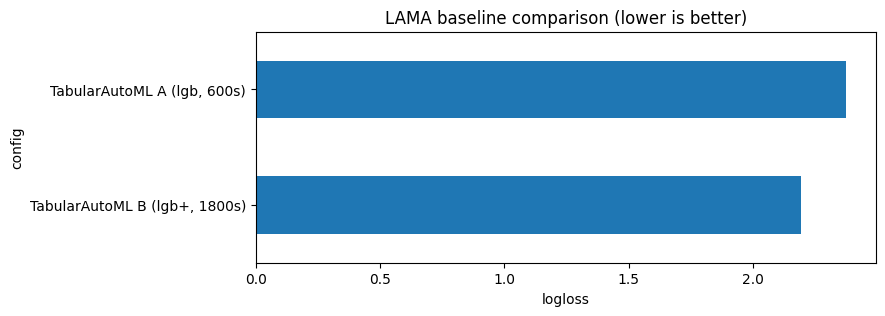

In [8]:
# Compare
results = pd.DataFrame(
    [
        {"config": "TabularAutoML A (lgb, 600s)", "logloss": score_a},
        {"config": "TabularAutoML B (lgb+, 1800s)", "logloss": score_b},
    ]
).sort_values("logloss")
display(results)

ax = results.set_index("config")["logloss"].plot(kind="barh", figsize=(8,3))
ax.set_title("LAMA baseline comparison (lower is better)")
ax.set_xlabel("logloss")
plt.show()

## Save best LAMA model + create submission

In [10]:
best_model = res_a.model if score_a <= score_b else res_b.model
best_name = "lama_a" if score_a <= score_b else "lama_b"

# Fit on full train and predict test
from lightautoml.tasks import Task
from lightautoml.automl.presets.tabular_presets import TabularAutoML

roles = {"target": TARGET_COL, "drop": drop_cols + spec["text_cols"]}
task = Task("multiclass")

automl_full = TabularAutoML(
    task=task,
    timeout=1800,
    cpu_limit=4,
    general_params={"use_algos": [["lgb", "cb"], ["lgb_tuned", "cb_tuned"]]},
)
_ = automl_full.fit_predict(train_df, roles=roles, verbose=2)
test_pred = automl_full.predict(test_df).data

sub = pd.DataFrame({ID_COL: test_df[ID_COL].values})
sub[labels] = test_pred

out_path = paths.submissions / f"submission_{best_name}.csv"
out_path.parent.mkdir(parents=True, exist_ok=True)
sub.to_csv(out_path, index=False)
print("Saved submission:", out_path)
sub.head()

[13:47:03] Stdout logging level is INFO2.
[13:47:03] Task: multiclass

[13:47:03] Start automl preset with listed constraints:
[13:47:03] - time: 1800.00 seconds
[13:47:03] - CPU: 4 cores
[13:47:03] - memory: 16 GB

[13:47:03] Train data shape: (49352, 34)

[13:47:07] Layer 1 train process start. Time left 1795.96 secs
[13:47:17] Selector_LightGBM fitting and predicting completed
[13:47:19] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[13:47:19] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:47:36] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:47:52] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:48:07] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:48:24] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LightGBM =====
[13:48:41] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.5805689196319649
[13:48:41] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting complete

Optimization Progress:  15%|█▍        | 15/101 [03:41<21:09, 14.76s/it, best_trial=10, best_value=-0.586]

[13:54:02] Hyperparameters optimization for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM completed
[13:54:02] The set of hyperparameters {'feature_fraction': 0.6229610028762618, 'num_leaves': 17, 'bagging_fraction': 0.9515481201295128, 'min_sum_hessian_in_leaf': 0.024400771927662247, 'reg_alpha': 0.0025077894820478477, 'reg_lambda': 0.016301353379407614}
 achieve -0.5860 crossentropy
[13:54:02] Start fitting Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM ...
[13:54:02] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====


[13:54:04] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
[13:54:07] ===== Start working with fold 2 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
[13:54:09] ===== Start working with fold 3 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
[13:54:11] ===== Start working with fold 4 for Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM =====
[13:54:13] Fitting Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM finished. score = -0.58007622874815
[13:54:13] Lvl_1_Pipe_0_Mod_0_Tuned_LightGBM fitting and predicting completed
[13:54:13] Start hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:  77%|███████▋  | 78/101 [05:06<01:30,  3.92s/it, best_trial=25, best_value=-0.586]

[13:59:19] Hyperparameters optimization for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost completed
[13:59:19] The set of hyperparameters {'max_depth': 6, 'l2_leaf_reg': 0.1352575417538152, 'min_data_in_leaf': 3}
 achieve -0.5861 crossentropy
[13:59:19] Start fitting Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost ...
[13:59:19] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====


[13:59:23] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====
[13:59:28] ===== Start working with fold 2 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====
[13:59:32] ===== Start working with fold 3 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====
[13:59:37] ===== Start working with fold 4 for Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost =====
[13:59:41] Fitting Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost finished. score = -0.5801419359547988
[13:59:41] Lvl_1_Pipe_0_Mod_1_Tuned_CatBoost fitting and predicting completed
[13:59:41] Time left 1041.91 secs

[13:59:41] Layer 2 training completed.

[13:59:41] Blending: optimization starts with equal weights. Score = -0.5793938
[13:59:41] Blending: iteration 0: score = -0.5793935, weights = [0.5088854  0.49111462]
[13:59:41] Blending: no improvements for score. Terminated.

[13:59:41] Blending: best score = -0.5793935, best weights = [0.5088854  0.49111462]
[13:59:41] Automl preset training completed in 758.26 seconds

[13:59:41] Model description:
M

,listing_id,high,medium,low
0,7142618,0.551395,0.374070,0.074535
1,7210040,0.211792,0.472225,0.315982
2,7174566,0.982254,0.015343,0.002403
3,7191391,0.285183,0.397260,0.317557
4,7171695,0.894467,0.097004,0.008529
